# The Wilson-Cowan model

The Wilson-Cowan model is a rate model that describes the behavior of two interacting populations of neurons, an excitatory and an inhibitory one. It can be represented schematically by the following figure:

<img src="rate_model.png" width="400px"/>

The model is described by two ordinary differential  equations:

$
\tau_E \frac{d\nu_E}{dt} = -\nu_E + F_E\left(w_{EE}\nu_E - w_{IE}\nu_I + I_E^{\mathrm{ext}}\right) \\
\tau_I \frac{d\nu_I}{dt} = -\nu_I + F_I\left(w_{EI}\nu_E - w_{II}\nu_I + I_I^{\mathrm{ext}}\right)
$

where $\nu_E$ and $\nu_I$ are the firing rates of the excitatory and inhibitory populations, respectively, and $F_E$ and $F_I$ are the functions that describe how a certain amount of synaptic current is converted into a population firing rate. For simplicity, in the following we will use the same function for both excitatory and inhibitory populations, given by

$F(I,\alpha,\theta) = \frac{1}{1 + \exp\left[-\alpha(I-\theta)\right]} - \frac{1}{1+\exp(\alpha\theta)}$,

where $\alpha$ and $\theta$ set the steepness and the rheobase of the function, respectively, and will be different for the two populations.

The weigths $w_{EE}$ ($E\rightarrow E$), $w_{IE}$ ($I\rightarrow E$), $w_{EI}$ ($E\rightarrow I$) and $w_{II}$ ($I\rightarrow I$) convert the appropriate firing rate into a total synaptic current.

The purpose of this notebook is to show how the tools of dynamical systems theory that have been introduced at the beginning of the course can be suitably applied to the analysis of the dynamics of the Wilson-Cowan model.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns

Here we define the functions that will be used in the following: the presence of the function $F$ makes the problem of finding both the equilibria and the nullclines implicit and therefore we will use the function `fsolve` to find the solutions.

In [2]:
F = lambda x,a,θ: 1/(1+np.exp(-a*(x-θ))) - 1/(1+np.exp(a*θ))

def WilsonCowan(t, y, p):
    nu_e,nu_i = y
    w_ee,w_ei,w_ie,w_ii = p[:4]
    tau_e,a_e,theta_e,nu_ext_e = p[4:8]
    tau_i,a_i,theta_i,nu_ext_i = p[8:12]
    return np.array([
        (-nu_e + F(w_ee*nu_e - w_ie*nu_i + nu_ext_e, a_e, theta_e)) / tau_e,
        (-nu_i + F(w_ei*nu_e - w_ii*nu_i + nu_ext_i, a_i, theta_i)) / tau_i,
    ])

def WilsonCowan_jac(t, y, p):
    import torch
    from torch.autograd.functional import jacobian
    w_ee,w_ei,w_ie,w_ii = p[:4]
    tau_e,a_e,theta_e,nu_ext_e = p[4:8]
    tau_i,a_i,theta_i,nu_ext_i = p[8:12]
    f = lambda x,a,θ: 1/(1+torch.exp(-a*(x-θ))) - 1/(1+torch.exp(torch.tensor(a*θ)))
    WC_1 = lambda x: (-x[0] + f(w_ee*x[0] - w_ie*x[1] + nu_ext_e, a_e, theta_e)) / tau_e
    WC_2 = lambda x: (-x[1] + f(w_ei*x[0] - w_ii*x[1] + nu_ext_i, a_i, theta_i)) / tau_i
    x = torch.tensor(y)
    return np.array([
        jacobian(WC_1, x).numpy(),
        jacobian(WC_2, x).numpy()
    ])

def WilsonCowan_equil(pars):
    norm = lambda x: np.sqrt(np.sum(x**2))
    equil,norms,stable = [], [], []
    for y0 in [0, 0.5, 1]:
        eq = fsolve(lambda x: WilsonCowan(0,x,pars), np.array([y0,y0]))
        if norm(eq) not in norms:
            norms.append(norm(eq))
            equil.append(eq)
            J = WilsonCowan_jac(0, eq, pars)
            eigval,_ = np.linalg.eig(J)
            stable.append(np.all(eigval.real < 0))
    return np.array(equil), np.array(stable,dtype=bool)

def WilsonCowan_nullclines(p, nu_e_limits=[0,1], n_points=100):
    w_ee,w_ei,w_ie,w_ii = p[:4]
    tau_e,a_e,theta_e,nu_ext_e = p[4:8]
    tau_i,a_i,theta_i,nu_ext_i = p[8:12]
    nu_e = np.linspace(nu_e_limits[0], nu_e_limits[1], n_points)
    null_nu_e_fun = lambda x,νe: - νe + F(w_ee*νe - w_ie*x + nu_ext_e, a_e, theta_e)
    null_nu_i_fun = lambda x,νe: - x + F(w_ei*νe - w_ii*x + nu_ext_i, a_i, theta_i)
    return np.array([fsolve(null_nu_e_fun, [νe], args=(νe,))[0] for νe in nu_e]), \
        np.array([fsolve(null_nu_i_fun, [νe], args=(νe,))[0] for νe in nu_e]), nu_e

Define the parameters of the model:

In [3]:
w_ee = 9   # E -> E
w_ei = 13  # E -> I
w_ie = 4   # I -> E
w_ii = 11  # I -> I

tau_e,a_e,theta_e,nu_ext_e = 1e-3, 1.2, 2.8, 0
tau_i,a_i,theta_i,nu_ext_i = 2e-3, 1.0, 4.0, 0

pars = w_ee,w_ei,w_ie,w_ii,tau_e,a_e,theta_e,nu_ext_e,tau_i,a_i,theta_i,nu_ext_i

Find the equilibria of the system (with their stability) and the nullclines:

In [4]:
equil,stable = WilsonCowan_equil(pars)
nu_i_null_1, nu_i_null_2, nu_e = WilsonCowan_nullclines(pars)

/usr/local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Plot the results:

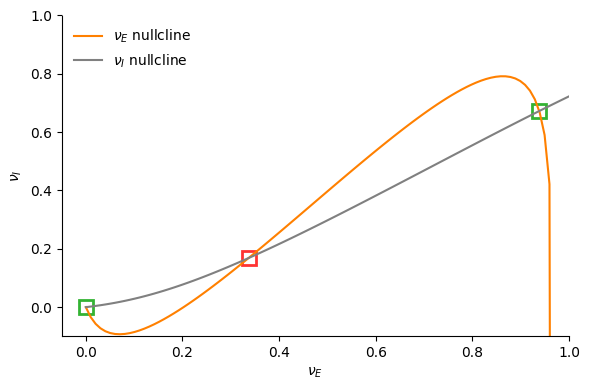

In [5]:
orange = [1,.5,0]
gray = [.5,.5,.5]

fig,ax = plt.subplots(1, 1, figsize=(6,4))
for eq,st in zip(equil,stable):
    col = [.2,.7,.2] if st else [1,.2,.2]
    ax.plot(eq[0], eq[1], 's', color=col, markersize=10, markerfacecolor='w', markeredgewidth=2)
ax.plot(nu_e, nu_i_null_1, color=orange, label=r'$\nu_E$ nullcline')
ax.plot(nu_e, nu_i_null_2, color=gray, label=r'$\nu_I$ nullcline')
ax.legend(loc='upper left', frameon=False, fontsize=10)
ax.set_xlim([-0.05, 1])
ax.set_ylim([-0.1, 1])
ax.set_xlabel(r'$\nu_E$')
ax.set_ylabel(r'$\nu_I$')
sns.despine()
fig.tight_layout()

Integrate the system for two different initial conditions:

In [6]:
t_span = np.array([0, 50e-3])
y0_low_rates = [0.32, 0.15]
y0_high_rates = [0.33, 0.15]
sol_low_rates = solve_ivp(WilsonCowan, t_span, y0_low_rates, args=(pars,), rtol=1e-8, atol=1e-10)
sol_high_rates = solve_ivp(WilsonCowan, t_span, y0_high_rates, args=(pars,), rtol=1e-8, atol=1e-10)

Plot the results:

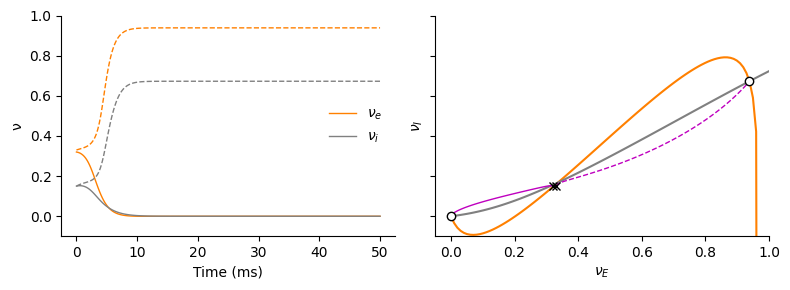

In [7]:
fig,ax = plt.subplots(1, 2, figsize=(8,3), sharey=True)
ax[0].plot(sol_low_rates.t*1e3, sol_low_rates.y[0], color=orange, lw=1, label=r'$\nu_e$')
ax[0].plot(sol_low_rates.t*1e3, sol_low_rates.y[1], color=gray, lw=1, label=r'$\nu_i$')
ax[0].plot(sol_high_rates.t*1e3, sol_high_rates.y[0], '--', color=orange, lw=1)
ax[0].plot(sol_high_rates.t*1e3, sol_high_rates.y[1], '--', color=gray, lw=1)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('ν')
ax[0].legend(loc='best', frameon=False, fontsize=10)


ax[1].plot(nu_e, nu_i_null_1, color=orange)
ax[1].plot(nu_e, nu_i_null_2, color=gray)
ax[1].plot(sol_low_rates.y[0], sol_low_rates.y[1], 'm', lw=1)
ax[1].plot(sol_high_rates.y[0], sol_high_rates.y[1], 'm--', lw=1)
ax[1].plot(sol_low_rates.y[0,0], sol_low_rates.y[1,0], 'kx', markersize=6, markeredgewidth=1)
ax[1].plot(sol_low_rates.y[0,-1], sol_low_rates.y[1,-1], 'ko', markerfacecolor='w',
           markersize=6, markeredgewidth=1)
ax[1].plot(sol_high_rates.y[0,0], sol_high_rates.y[1,0], 'kx', markersize=6, markeredgewidth=1)
ax[1].plot(sol_high_rates.y[0,-1], sol_high_rates.y[1,-1], 'ko', markerfacecolor='w',
           markersize=6, markeredgewidth=1)
ax[1].set_xlim([-0.05, 1])
ax[1].set_ylim([-0.1, 1])
ax[1].set_xlabel(r'$\nu_E$')
ax[1].set_ylabel(r'$\nu_I$')

sns.despine()
fig.tight_layout()